# Process Kuppe et al. data

## Set up Env

In [1]:
import os
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix

In [2]:
import liana as li

In [3]:
# load muon and mofax
import muon as mu
import mofax as mofa

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
from prep_utils import filter_samples, filter_celltypes

### Load data

In [5]:
adata = sc.read_h5ad(os.path.join('data', "kuppe.h5ad"), backed='r')

In [6]:
msk = np.array([patient in ['ischemic', 'myogenic'] for patient in adata.obs['patient_group']])
adata = adata[msk]

Params

In [7]:
groupby = 'cell_type'
sample_key = 'sample'
condition_key = 'patient_group'
batch_key = 'sex'

min_cells_per_sample = 700
sample_zcounts_max = 3
sample_zcounts_min = -2

# set filtering parameters
min_cells = 10 # min number of cells per cell type
min_samples = 5 # min number of samples that pass the threshold per cell type

In [8]:
# NOTE: I use .raw
adata = adata.raw.to_adata()
adata.X = csr_matrix(adata.X)

In [9]:
# change to gene symbols
adata.var.index = adata.var['feature_name']

Filter samples, cell types, and genes

In [10]:
adata = filter_samples(adata, sample_key, condition_key, min_cells_per_sample, sample_zcounts_max, sample_zcounts_min)

               sample
patient_group        
ischemic           10
myogenic           13


In [11]:
adata = filter_celltypes(adata=adata, groupby=groupby, sample_key=sample_key, min_cells=min_cells, min_samples=min_samples)

In [12]:
# Remove genes expressed in few cells, normalize
sc.pp.filter_genes(adata, min_cells=30)
adata

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


AnnData object with n_obs × n_vars = 165129 × 26305
    obs: 'sample', 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'dissociation_score', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'final_cluster', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells'
    uns: 'X_approximate_distribution', 'batch_condition', 'cell_type_colors', 'cell_type_original_colors', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [13]:
import gc
gc.collect()

2789

##### Abbrevaite Cell types

In [14]:
cell_type_abbreviations = {'neuronal receptor cell': 'NRC',
    'mast cell': 'MC',
    'cardiac muscle myoblast': 'CMM',
    'smooth muscle myoblast': 'SMM',
    'pericyte': 'PC',
    'lymphoid lineage restricted progenitor cell': 'LLRPC',
    'immature innate lymphoid cell': 'IILC',
    'fibroblast of cardiac tissue': 'FCT',
    'cardiac endothelial cell': 'CEC',
    'adipocyte of epicardial fat of left ventricle': 'AEFLV',
    'native cell': 'NC'
}

In [15]:
# use the replace() method to recode the cell_type column
adata.obs['cell_abbr'] = adata.obs['cell_type'].replace(cell_type_abbreviations)

In [16]:
# change groupby to abbreviation
groupby = 'cell_abbr'

### Normalize

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Run LIANA

In [18]:
li.mt.singlecellsignalr.by_sample(adata, groupby=groupby, use_raw=False, sample_key=sample_key, verbose=True, n_perms=None)

Now running: CK376: 100%|██████████| 23/23 [02:42<00:00,  7.05s/it]


In [19]:
mdata = li.multi.lrs_to_views(adata,
                              sample_key=sample_key,
                              score_key='lrscore',
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.2, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 10, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 10, # minimum number of interactions to keep a view
                              samples_per_view = 8, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0, # fill missing LR values across samples with this
                              verbose=True
                              )

100%|██████████| 121/121 [00:02<00:00, 42.03it/s]


In [20]:
mdata

MuData object with n_obs × n_vars = 23 × 38984
  obs:	'patient_group'
  119 modalities
    NRC&NRC:	23 x 371
    MC&NRC:	19 x 272
    CMM&NRC:	23 x 428
    SMM&NRC:	23 x 455
    PC&NRC:	23 x 390
    LLRPC&NRC:	23 x 281
    IILC&NRC:	23 x 306
    FCT&NRC:	23 x 454
    CEC&NRC:	23 x 329
    NC&NRC:	23 x 393
    NRC&MC:	19 x 305
    MC&MC:	19 x 280
    CMM&MC:	19 x 360
    SMM&MC:	19 x 363
    PC&MC:	19 x 301
    LLRPC&MC:	19 x 229
    IILC&MC:	19 x 278
    FCT&MC:	19 x 387
    CEC&MC:	19 x 289
    NC&MC:	19 x 340
    NRC&CMM:	23 x 419
    MC&CMM:	19 x 349
    CMM&CMM:	23 x 497
    SMM&CMM:	23 x 480
    PC&CMM:	23 x 425
    LLRPC&CMM:	23 x 327
    IILC&CMM:	23 x 358
    FCT&CMM:	23 x 487
    CEC&CMM:	23 x 395
    NC&CMM:	23 x 477
    NRC&SMM:	23 x 407
    MC&SMM:	19 x 324
    CMM&SMM:	23 x 447
    SMM&SMM:	23 x 461
    PC&SMM:	23 x 412
    LLRPC&SMM:	23 x 308
    IILC&SMM:	23 x 343
    FCT&SMM:	23 x 470
    CEC&SMM:	23 x 379
    NC&SMM:	23 x 439
    NRC&PC:	23 x 303
    MC&PC:	19 x 240
    CMM&PC:	23 x 352
    SMM&PC:	23 x 360
    PC&PC:	23 x 320
    LLRPC&PC:	23 x 234
    IILC&PC:	23 x 255
    FCT&PC:	23 x 358
    CEC&PC:	23 x 299
    NC&PC:	23 x 335
    NRC&LLRPC:	22 x 253
    MC&LLRPC:	18 x 194
    CMM&LLRPC:	23 x 295
    SMM&LLRPC:	23 x 302
    PC&LLRPC:	22 x 274
    LLRPC&LLRPC:	21 x 217
    IILC&LLRPC:	22 x 233
    FCT&LLRPC:	23 x 312
    CEC&LLRPC:	21 x 259
    NC&LLRPC:	22 x 284
    NRC&IILC:	23 x 291
    MC&IILC:	19 x 275
    CMM&IILC:	23 x 355
    SMM&IILC:	23 x 349
    PC&IILC:	23 x 298
    LLRPC&IILC:	23 x 237
    IILC&IILC:	23 x 287
    FCT&IILC:	23 x 359
    CEC&IILC:	23 x 292
    NC&IILC:	23 x 352
    NRC&FCT:	23 x 358
    MC&FCT:	19 x 301
    CMM&FCT:	23 x 407
    SMM&FCT:	23 x 419
    PC&FCT:	23 x 369
    LLRPC&FCT:	23 x 279
    IILC&FCT:	23 x 299
    FCT&FCT:	23 x 417
    CEC&FCT:	23 x 335
    NC&FCT:	23 x 401
    NRC&CEC:	23 x 344
    MC&CEC:	19 x 252
    CMM&CEC:	23 x 404
    SMM&CEC:	23 x 389
    PC&CEC:	23 x 341
    LLRPC&CEC:	23 x 262
    IILC&CEC:	23 x 292
    FCT&CEC:	23 x 402
    CEC&CEC:	23 x 332
    NC&CEC:	23 x 386
    NRC&NC:	23 x 417
    MC&NC:	19 x 346
    CMM&NC:	23 x 489
    SMM&NC:	23 x 474
    PC&NC:	23 x 421
    LLRPC&NC:	23 x 328
    IILC&NC:	23 x 369
    FCT&NC:	23 x 500
    CEC&NC:	23 x 400
    NC&NC:	23 x 486
    AEFLV&NRC:	9 x 201
    AEFLV&CMM:	9 x 261
    AEFLV&SMM:	9 x 242
    AEFLV&PC:	9 x 175
    AEFLV&LLRPC:	9 x 130
    AEFLV&IILC:	9 x 183
    AEFLV&FCT:	9 x 230
    AEFLV&CEC:	9 x 204
    NRC&AEFLV:	9 x 205
    CMM&AEFLV:	9 x 256
    SMM&AEFLV:	9 x 244
    PC&AEFLV:	9 x 223
    LLRPC&AEFLV:	9 x 138
    IILC&AEFLV:	9 x 166
    FCT&AEFLV:	9 x 267
    CEC&AEFLV:	9 x 216
    AEFLV&AEFLV:	9 x 213
    NC&AEFLV:	9 x 203
    AEFLV&NC:	9 x 219

In [21]:
mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           outfile='models/mofatalk.h5ad',
           n_factors=5,
           )



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='NRC&NRC' group='group1' with N=23 samples and D=371 features...
Loaded view='MC&NRC' group='group1' with N=23 samples and D=272 features...
Loaded view='CMM&NRC' group='group1' with N=23 samples and D=428 features...
Loaded view='SMM&NRC' group='group1' with N=23 samples and D=455 features...
Loaded view='PC&NRC' group='group1' with N=23 samples and D=390 features..

In [22]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()

,sample,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,patient_group
0,CK158,-0.320582,-0.125324,-0.053954,-0.025256,0.007541,myogenic
1,CK159,0.145553,-0.255193,0.179529,-0.105322,0.232393,myogenic
2,CK160,-0.245525,0.196747,-0.043813,0.174845,0.054652,myogenic
3,CK163,-0.136489,-0.193852,0.035947,0.135617,-0.055540,myogenic
4,CK164,-0.276102,0.198459,-0.051535,0.180911,0.062962,myogenic


In [23]:
factor_scores.sort_values('Factor_1', ascending=False)

,sample,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,patient_group
16,CK369,0.682201,-0.140125,-0.093518,-0.010629,0.006942,ischemic
18,CK372,0.675736,-0.137046,-0.087467,-0.012686,0.005957,ischemic
21,CK375,0.669223,-0.138316,-0.091973,-0.011666,0.008383,ischemic
22,CK376,0.668535,-0.132088,-0.094047,-0.011358,0.006543,ischemic
5,CK165,0.306884,-0.032227,0.233723,0.090411,-0.206681,ischemic
1,CK159,0.145553,-0.255193,0.179529,-0.105322,0.232393,myogenic
11,CK361,0.145447,0.035800,0.158121,-0.097388,-0.131993,ischemic
15,CK365,0.003966,0.458302,0.053072,-0.061513,-0.001248,ischemic
19,CK373,-0.011487,0.460824,0.049559,-0.060906,0.001470,ischemic
13,CK363,-0.012627,0.406693,0.042479,-0.059761,0.011337,ischemic


write adata with LIANA results

In [24]:
adata.write_h5ad(os.path.join('data', "kuppe_processed.h5ad"))

## Classify

In [78]:
import plotnine as p9
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [79]:
clf = RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=0,
        )

In [80]:
X = mdata.obsm['X_mofa']
y = mdata.obs[condition_key]

In [81]:
# Range of `n_estimators` values to explore.
min_estimators = 2
max_estimators = 500
error_rate = []

In [82]:
for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)
        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate.append((i, oob_error))

In [83]:
clf

RandomForestClassifier(max_features=None, n_estimators=497, oob_score=True,
                       random_state=0, warm_start=True)

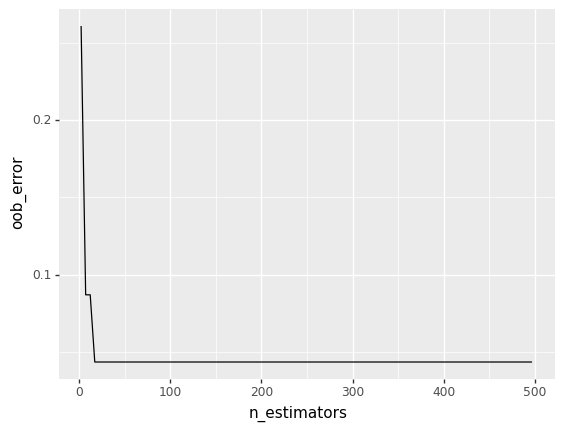

<ggplot: (8732567383644)>

In [84]:
# plotnine line plot
(p9.ggplot(pd.DataFrame(error_rate, columns=['n_estimators', 'oob_error'])) + p9.aes(x='n_estimators', y='oob_error') + p9.geom_line())

In [85]:
from sklearn.model_selection import cross_validate

In [86]:
scores = cross_validate(clf, X, y, cv=5, scoring=['roc_auc'])['test_roc_auc']

In [87]:
scores

array([0.75, 1.  , 1.  , 1.  , 1.  ])

In [88]:
print("%0.2f mean roc_auc with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.95 mean roc_auc with a standard deviation of 0.10


Classify

In [180]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import numpy as np

import matplotlib.pyplot as plt

In [212]:
X = mdata.obsm['X_mofa']
y = mdata.obs[condition_key]

In [213]:
from sklearn.preprocessing import LabelEncoder

In [214]:
# create a LabelEncoder object & and transform the labels
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [215]:
n_estimators = 500
n_splits = 5

In [216]:
clf = RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=0,
            n_estimators=200
        )
cv = StratifiedKFold(n_splits=n_splits)
y_prob = np.zeros_like(y, dtype=float)

In [218]:
# initialize DataFrame to store results
results_df = pd.DataFrame(columns=['fold', 'auc', 'tpr', 'fpr'])

In [220]:
for fold, (train, test) in enumerate(cv.split(X, y)):
    clf_tmp = clf.fit(X[train], y[train])
    y_prob[test] = clf_tmp.predict_proba(X[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y[test], y_prob[test])
    
    roc_auc = auc(fpr, tpr)
    results_df = results_df.append({'fold': fold+1, 'auc': roc_auc, 'tpr': tpr, 'fpr': fpr}, ignore_index=True)


In [223]:
# calculate mean and standard deviation of AUC across folds
mean_auc = results_df['auc'].mean()
std_auc = results_df['auc'].std()

# print mean and standard deviation of AUC
print("Mean AUC:", mean_auc)
print("Standard deviation of AUC:", std_auc)

Mean AUC: 0.95
Standard deviation of AUC: 0.11180339887498947
